In [1]:
import sys
import os

# Add project root to Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.insert(0, project_root)

print("Project root added to path:", project_root)

Project root added to path: /Users/krishna/Desktop/NIRANJAN/rl-derivative_hedging


In [2]:
%pip install yfinance
%pip install scipy
%pip install matplotlib
%pip install stable-baselines3 gymnasium

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import yfinance as yf
data = yf.download("SPY", start="2018-01-01", end="2023-01-01")
print(data.head())

/Users/krishna/Desktop/NIRANJAN/rl-derivative_hedging/.venv/lib/python3.13/site-packages/yfinance/scrapers/history.py:201: Pandas4Warning: Timestamp.utcnow is deprecated and will be removed in a future version. Use Timestamp.now('UTC') instead.
  dt_now = pd.Timestamp.utcnow()
[*********************100%***********************]  1 of 1 completed

Price            Close        High         Low        Open    Volume
Ticker             SPY         SPY         SPY         SPY       SPY
Date                                                                
2018-01-02  237.208206  237.243516  235.999090  236.387423  86655700
2018-01-03  238.708618  238.858667  237.375929  237.375929  90070400
2018-01-04  239.714737  240.200166  238.770408  239.352907  80636400
2018-01-05  241.312195  241.435741  240.014816  240.509053  83524000
2018-01-08  241.753387  241.912243  240.923770  241.215006  57319200


In [4]:
print(data.shape)
print(data.columns)

(1259, 5)
MultiIndex([( 'Close', 'SPY'),
            (  'High', 'SPY'),
            (   'Low', 'SPY'),
            (  'Open', 'SPY'),
            ('Volume', 'SPY')],
           names=['Price', 'Ticker'])


In [5]:
from pricing.black_scholes import bs_call_price, bs_delta, bs_gamma

S = 100
K = 100
T = 1.0
r = 0.05
sigma = 0.2

print("Call Price:", bs_call_price(S, K, T, r, sigma))
print("Delta:", bs_delta(S, K, T, r, sigma))
print("Gamma:", bs_gamma(S, K, T, r, sigma))

Call Price: 10.450583572185565
Delta: 0.6368306511756191
Gamma: 0.018762017345846895


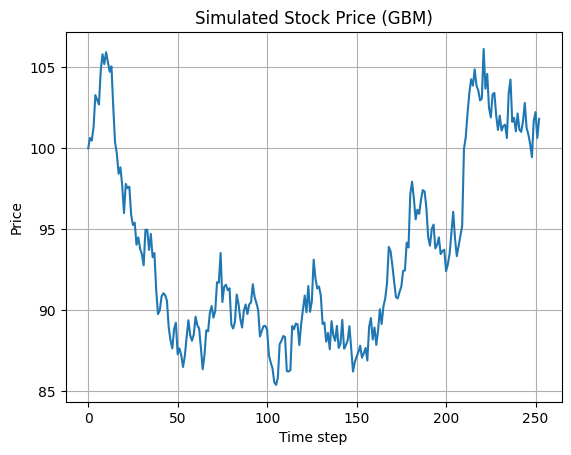

In [6]:
from simulator.gbm import simulate_gbm
import matplotlib.pyplot as plt

prices = simulate_gbm(
    S0=100,
    mu=0.05,
    sigma=0.2,
    T=1.0,
    steps=252,
    seed=42
)

plt.plot(prices)
plt.title("Simulated Stock Price (GBM)")
plt.xlabel("Time step")
plt.ylabel("Price")
plt.grid(True)
plt.show()

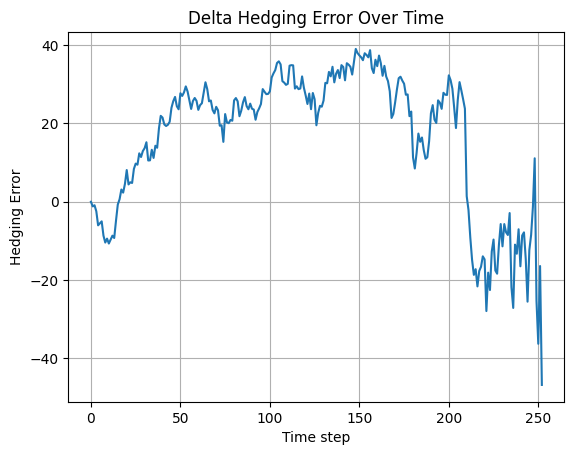

In [7]:
from simulator.gbm import simulate_gbm
from benchmarks.delta_hedging import delta_hedge
import matplotlib.pyplot as plt

# Simulate stock prices
prices = simulate_gbm(
    S0=100,
    mu=0.05,
    sigma=0.2,
    T=1.0,
    steps=252,
    seed=42
)

# Run delta hedging
result = delta_hedge(
    prices=prices,
    K=100,
    r=0.05,
    sigma=0.2,
    T=1.0
)

# Plot hedging error
plt.plot(result["hedging_error"])
plt.title("Delta Hedging Error Over Time")
plt.xlabel("Time step")
plt.ylabel("Hedging Error")
plt.grid(True)
plt.show()

In [9]:
from env.hedging_env import HedgingEnv
env = HedgingEnv()

In [14]:
obs, _ = env.reset()

print("Initial state:", obs)
print("=" * 50)

for step in range(3):
    action = env.action_space.sample()  # RANDOM action
    obs, reward, done, _, _ = env.step(action)

    print(f"Step {step}")
    print("Action taken:", action)
    print("Reward received:", reward)
    print("New state:", obs)
    print("-" * 50)

    if done:
        break

Initial state: [1.0000000e+02 6.3683063e-01 1.8762017e-02 1.0000000e+00 2.0000000e-01
 0.0000000e+00]
Step 0
Action taken: [0.13213834]
Reward received: -0.2292278032871647
New state: [9.9112755e+01 6.1968589e-01 1.9251270e-02 9.9603176e-01 2.0000000e-01
 1.3213834e-01]
--------------------------------------------------
Step 1
Action taken: [0.77446204]
Reward received: -0.36956551365747053
New state: [9.6820717e+01 5.7394135e-01 2.0328056e-02 9.9206346e-01 2.0000000e-01
 9.0660036e-01]
--------------------------------------------------
Step 2
Action taken: [-0.5796449]
Reward received: -0.010514619021231027
New state: [9.6731430e+01 5.7171947e-01 2.0408846e-02 9.8809522e-01 2.0000000e-01
 3.2695547e-01]
--------------------------------------------------
